# Personal Information
Name: **Papadopoulos Dimitrios**

StudentID: **15240924**

Email: [**dimitrios.papadopoulos@student.uva.nl**](dimitrios.papadopoulos@student.uva.nl)

Submitted on: **22.03.2024**

GitHub Link: https://github.com/elsevier-health/dsls-papadopoulos-ambiguity-scoring-thesis


# Data Context

In this research, we will be utilising three datasets. The first two, OmniScience and Emtree/RMC, were provided by Elsevier and will not be made publicly available. **OmniScience** is a comprehensive dataset that spans all scientific domains. It is a rich source of scientific terms, making it an ideal resource for our study of term ambiguity in scientific literature. The dataset includes terms from a wide range of fields, from physics and chemistry to biology and social sciences, among others. Each term in the OmniScience dataset is associated with a unique identifier and is categorized under a high-level concept, providing a hierarchical structure that aids in understanding the context and domain of the term. The dataset also includes information about whether a term is considered ambiguous.

**Emtree/RMC** is a specialized dataset that focuses on the field of biomedicine. It is a curated collection of biomedical literature, providing a wealth of information specific to this domain. The dataset is structured to facilitate in-depth analysis, with each entry featuring a range of attributes relevant to our research. The Emtree/RMC dataset is continually updated, ensuring our research is based on the most current and relevant biomedical literature. This allows us to capture the evolving usage of terms, the emergence of new terminologies, and the nuances of term ambiguity within the biomedical domain. The focused nature of the Emtree/RMC dataset makes it an invaluable resource for our study of term ambiguity in scientific literature, particularly within the context of biomedicine.

Given that OmniScience and Emtree/RMC datasets are not open-source and hence not publicly available, we recognize the need for a dataset that can be openly accessed for research purposes. Therefore, we plan to create an additional dataset based on public data. For this purpose, we will utilize either the Unified Medical Language System (UMLS)\cite{noauthor_unified_nodate} or Medical Subject Headings (MeSH)\cite{noauthor_home_nodate}. Both UMLS and MeSH are reputable sources of biomedical terminologies and are widely used in the scientific community. UMLS integrates multiple biomedical vocabularies and standards to enable interoperability between computer systems. MeSH, on the other hand, is the National Library of Medicine’s controlled vocabulary thesaurus. It consists of sets of terms naming descriptors in a hierarchical structure that permits searching at various levels of specificity. By leveraging these resources, we aim to construct a dataset that mirrors the structure and complexity of the OmniScience and Emtree/RMC datasets. This will allow other researchers to replicate and extend our work, thereby contributing to the broader scientific community’s understanding of term ambiguity in scientific literature.

# Data Description

<!-- **Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.** -->

Even though most of the analysis is done with comments below, let's give some information here. Firstly, both OmniScience and Emtree datasets have the same columns:
- Super         (IRI for super node of the concept in the taxonomy)
- Concept       (IRI for the concept in the taxonomy)
- distance      (Count of steps required to get from super to concept)
- superLabel    (The label of the super)
- label         (The label of the concept)
- ambiguous     (The flag for the label in terms of ambiguity)

We first see that there are multiple rows for each concept, i.e. multiple labels and under multiple supers. Thus we create the list super_list, superLabel_list and label_list containing all the unique values of the according columns for each concept. There are 155720/57751 unique concepts with a mean of 4.3/1.7 rows per concept, a mean of 4.03/1.2 labels per concept, appearing under 1.17/1.37 supers in Emtree/OmniScience accordingly. 

As regards to the "Ambiguous" column, the datasets are unbalanced. The "ambiguous" which is the target variable for our experiments is True only 4.2% for Emtree and 1.8% for Omniscience. This makes it hard to train models on, so methods for balancing, like undersampling, oversampling etc will be used.  

As the transformer models that will be used in this thesis are trained and fine-tuned on text, we take a closer look at the column "label" which has the text that must be classified as ambiguous or not. We see that labels in Emtree consist of 1-60 words and a mean of 3.04 words per label. Furthermore, the mean of words in terms rises from 2.87 to 3.12 when comparing unambiguous to ambiguous words. Accordingly, in Omniscience labels consist of 1-21 words with a mean of 2.4 of words per label, while the mean of words in unambiguous is 2.36 and in ambiguous 3.23. 

Finally, the mean distance to super from the concept in Emtree is 10.2 and in OmniScience 8.6.

In [188]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import load_dataset
import matplotlib.pyplot as plt

## EDA for Emtree

### Data Loading

In [189]:
df_emtree = pd.read_csv("/home/dpapadopoulos/dsls-papadopoulos-ambiguity-scoring-thesis/Data/Emtree_RMC.csv")

### Analysis 1: Concepts
Let us see how many unique concepts there are, and how many times (rows/occurances) they appear in the taxonomy.

In [190]:
#Count number of times a concept appears 
counts_concept = df_emtree['concept'].value_counts().describe(percentiles=[.3, .6, .80, .90 ,.95])
counts_concept

count    155720.000000
mean          4.368373
std           6.451720
min           1.000000
30%           1.000000
50%           2.000000
60%           3.000000
80%           6.000000
90%          10.000000
95%          14.000000
max         305.000000
Name: count, dtype: float64

The emtree taxonomy has  155720.0  unique concepts, with  4.368372720267146 average rows per concept.


<function matplotlib.pyplot.show(close=None, block=None)>

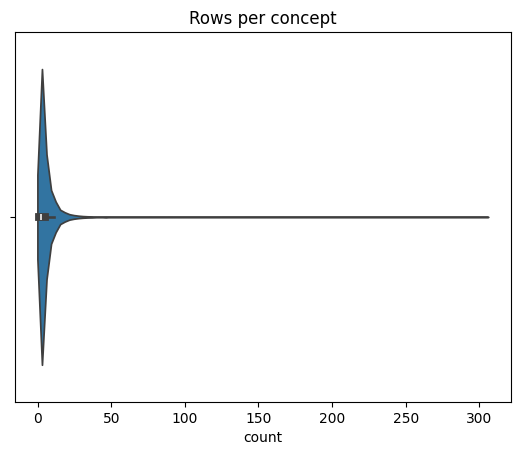

In [191]:
print("The emtree taxonomy has ", counts_concept['count'], " unique concepts, with ",counts_concept['mean'], "average rows per concept.")
sns.violinplot( x=df_emtree['concept'].value_counts())
plt.title("Rows per concept")
plt.show

### Analysis 2: Labels and supers

In [192]:
#Create lists for supers and labels for each concept
temp_df1 = df_emtree.groupby('concept')['superLabel'].apply(lambda x: list(x.unique())).reset_index().rename(columns={'superLabel': 'superLabel_list'})
temp_df2 = df_emtree.groupby('concept')['super'].apply(lambda x: list(x.unique())).reset_index().rename(columns={'super': 'super_list'})
temp_df3 = df_emtree.groupby('concept')['label'].apply(lambda x: list(x.unique())).reset_index().rename(columns={'label': 'label_list'})
df_emtree_proc = pd.merge(df_emtree, temp_df1, on='concept', how='left')
df_emtree_proc = pd.merge(df_emtree_proc, temp_df2, on='concept', how='left')
df_emtree_proc = pd.merge(df_emtree_proc, temp_df3, on='concept', how='left')

In [193]:
#print percentiles and mean for the length of super_list
descr_super = df_emtree_proc['super_list'].apply(len).describe(percentiles=[0.25,0.5,.75,.90,.99])
descr_super

count    680243.000000
mean          1.172956
std           0.479264
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
90%           2.000000
99%           3.000000
max           5.000000
Name: super_list, dtype: float64

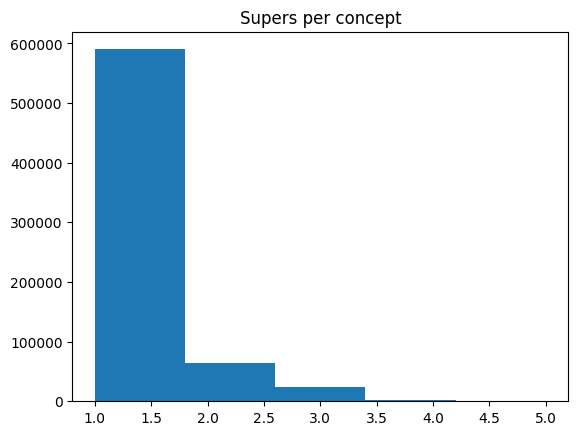

In [194]:
#Count unique supers that each concept has and plot it in a histogram
df_emtree_proc['super_list'].apply(len).value_counts()
plt.hist(df_emtree_proc['super_list'].apply(len),bins=int(descr_super['max']))
plt.title("Supers per concept")
plt.show()

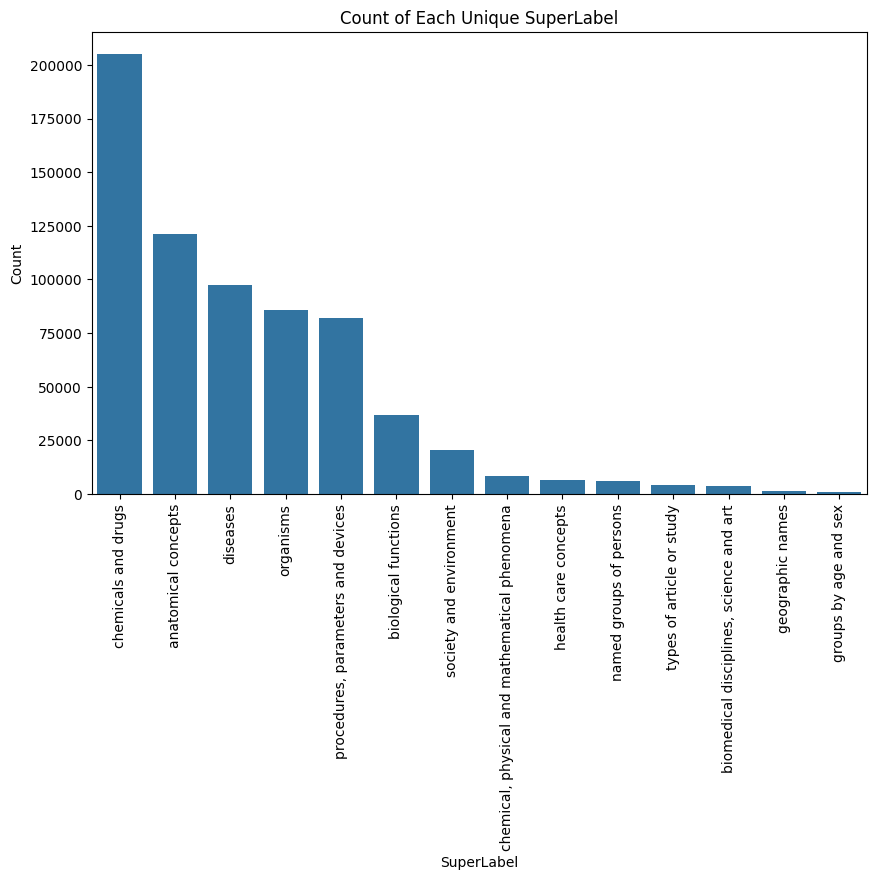

In [195]:
# Count the number of times each unique superLabel appears in the dataset
superLabel_counts = df_emtree_proc['superLabel'].value_counts().reset_index().rename(columns={'index': 'superLabel', 'superLabel': 'superLabel'})

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='superLabel', y='count', data=superLabel_counts)
plt.title('Count of Each Unique SuperLabel')
plt.xlabel('SuperLabel')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if they are long
plt.show()


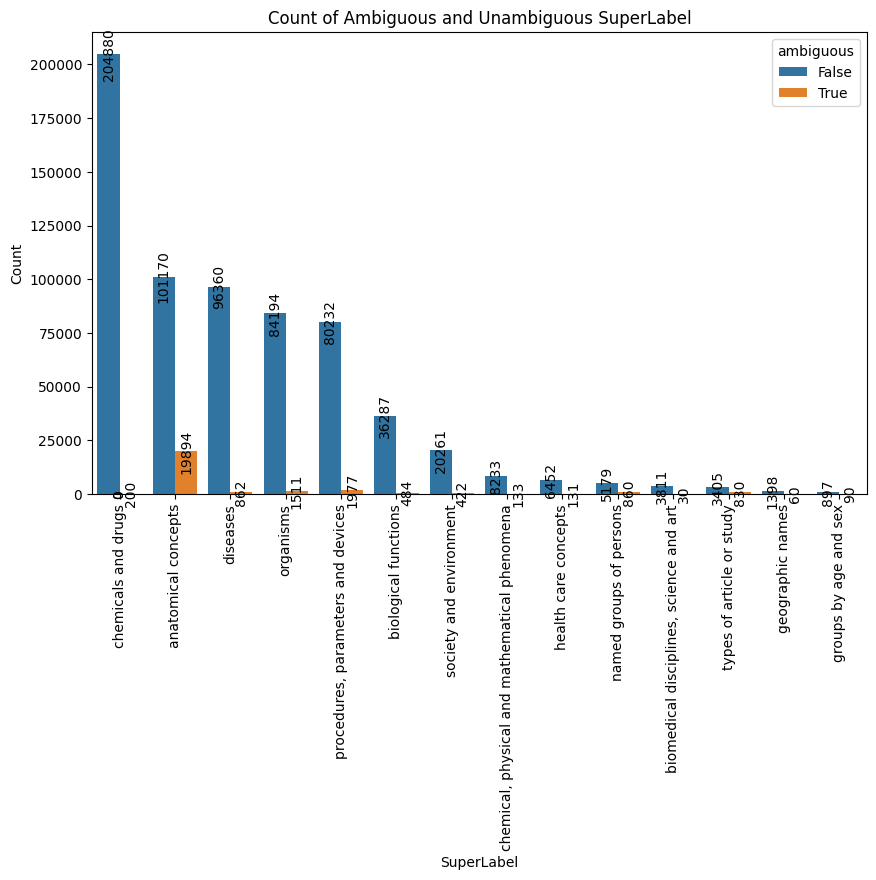

                                   SuperLabel  Unambiguous  Ambiguous  Full Count
                          anatomical concepts       101170      19894      121064
                         biological functions        36287        484       36771
      biomedical disciplines, science and art         3811         30        3841
chemical, physical and mathematical phenomena         8233        133        8366
                          chemicals and drugs       204880        200      205080
                                     diseases        96360        862       97222
                             geographic names         1398         60        1458
                        groups by age and sex          897         90         987
                         health care concepts         6452        131        6583
                      named groups of persons         5179        860        6039
                                    organisms        84194       1511       85705
           proce

In [196]:
# Sort the DataFrame by count
super_ambiguity_counts = df_emtree_proc.groupby(['superLabel', 'ambiguous']).size().reset_index(name='count')
super_ambiguity_counts = super_ambiguity_counts.sort_values('count', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='superLabel', y='count', hue='ambiguous', data=super_ambiguity_counts)

# Add the numbers inside the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 0), 
                      textcoords = 'offset points',
                      rotation=90)

plt.title('Count of Ambiguous and Unambiguous SuperLabel')
plt.xlabel('SuperLabel')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


# Transform the ambiguous column into two columns Ambiguous and Unambiguous``
super_ambiguity_counts_pivot = super_ambiguity_counts.pivot(index='superLabel', columns='ambiguous', values='count').reset_index()

# Rename the columns
super_ambiguity_counts_pivot.columns = ['SuperLabel', 'Unambiguous', 'Ambiguous']

# Replace NaN values with 0
super_ambiguity_counts_pivot = super_ambiguity_counts_pivot.fillna(0)

# Add a new column for the full count
super_ambiguity_counts_pivot['Full Count'] = super_ambiguity_counts_pivot['Ambiguous'] + super_ambiguity_counts_pivot['Unambiguous']

# Print the DataFrame
print(super_ambiguity_counts_pivot.to_string(index=False))



In [197]:
#print percentiles and mean for the length of label_list
df_emtree_proc['label_list'].apply(len).describe(percentiles=[0.25,0.5,.75,.90,.99])


count    680243.000000
mean         12.417943
std          20.162638
min           1.000000
25%           3.000000
50%           7.000000
75%          13.000000
90%          26.000000
99%          96.000000
max         305.000000
Name: label_list, dtype: float64

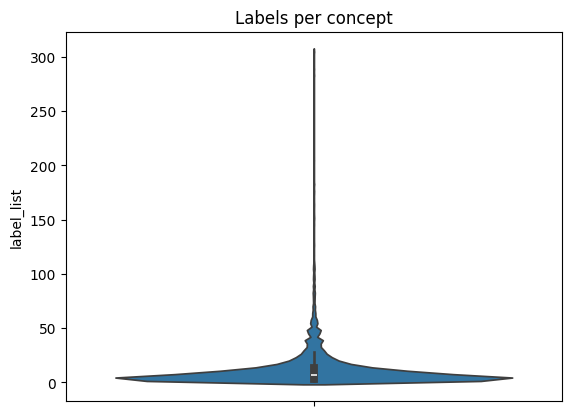

In [198]:
#Count unique labels that each concept and plot violinplot
df_emtree_proc['label_list'].apply(len).value_counts()
sns.violinplot( df_emtree_proc['label_list'].apply(len))
# plt.hist(df_emtree_proc['label_list'].apply(len),bins=5)
plt.title("Labels per concept")
plt.show()

### Analysis 3: Words per label

<function matplotlib.pyplot.show(close=None, block=None)>

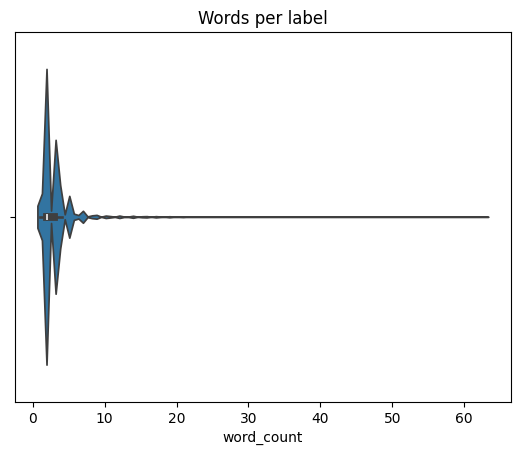

In [110]:
#Create word cound collumn 
df_emtree_proc['word_count'] = df_emtree_proc['label'].apply(lambda x: len(str(x).split()))
sns.violinplot( x=df_emtree_proc['word_count'])
plt.title("Words per label")
plt.show

In [111]:
#print percentiles and mean for word_count
descr_words = df_emtree_proc['word_count'].describe(percentiles=[0.25,0.5,.75,.8,.90,.99])
descr_words

count    680243.000000
mean          3.040036
std           2.597025
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
80%           4.000000
90%           5.000000
99%          16.000000
max          63.000000
Name: word_count, dtype: float64

In [112]:
#Define and remove outliers

# Define upper bound
upper_bound = df_emtree_proc['word_count'].quantile(0.99)
# upper_bound = 16

# Identify outliers
outliers = df_emtree_proc[df_emtree_proc['word_count'] > upper_bound]
print("Number of outliers:", len(outliers))

# Count the number of outliers that are ambiguous
ambiguous_outliers = outliers[outliers['ambiguous'] == True]
print("Number of ambiguous outliers:", len(ambiguous_outliers))

# Filter the DataFrame
df_emtree_proc = df_emtree_proc[df_emtree_proc['word_count'] <= upper_bound]

print("Number of records after removing outliers:", len(df_emtree_proc))


Number of outliers: 5584
Number of ambiguous outliers: 0
Number of records after removing outliers: 674659


### Analysis 4: Ambiguity


In [113]:
#show how many ambiguous and unambiguous labels there are
val_amb_emtree = df_emtree_proc['ambiguous'].value_counts()
print("Ratio = ",val_amb_emtree[True]/val_amb_emtree[False])
val_amb_emtree

Ratio =  0.04246764785413528


ambiguous
False    647175
True      27484
Name: count, dtype: int64

In [114]:
#Number of words in ambiguous
descr_words_amb = df_emtree_proc.loc[df_emtree_proc['ambiguous']==True,'word_count'].describe(percentiles=[0.25,0.5,.75,.90,.99])
descr_words_amb

count    27484.000000
mean         3.125891
std          1.057190
min          2.000000
25%          2.000000
50%          3.000000
75%          3.000000
90%          4.000000
99%          7.000000
max         13.000000
Name: word_count, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

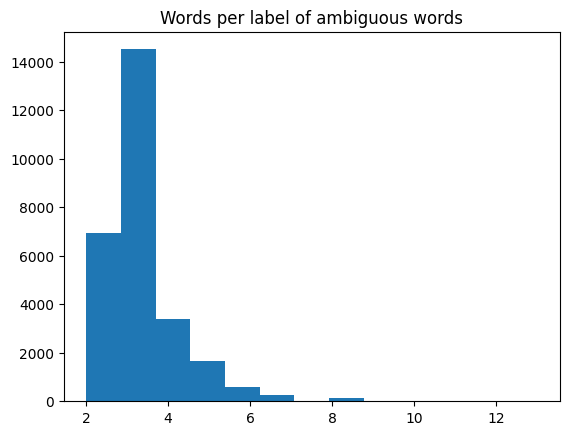

In [115]:
plt.hist(df_emtree_proc.loc[df_emtree_proc['ambiguous']==True,'word_count'],bins=int(descr_words_amb['max']))
# sns.violinplot( x=df_emtree_proc.loc[df_emtree_proc['ambiguous']==True,'word_count'])
plt.title("Words per label of ambiguous words")

plt.show

In [116]:
#Number of words in unambiguous
descr_words_unamb = df_emtree_proc.loc[df_emtree_proc['ambiguous']==False,'word_count'].describe(percentiles=[0.25,0.5,.75,.90])
descr_words_unamb

count    647175.000000
mean          2.877988
std           1.963707
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
90%           5.000000
max          16.000000
Name: word_count, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

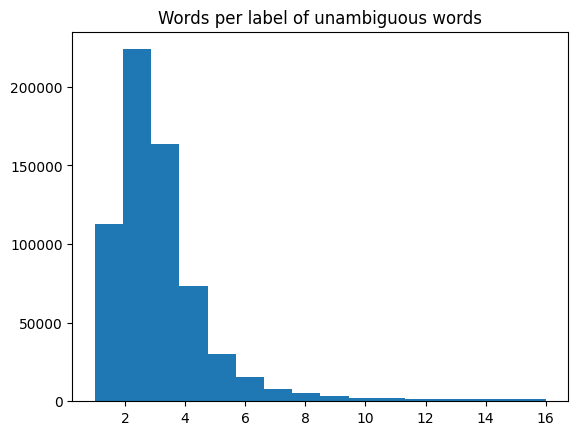

In [117]:
plt.hist(df_emtree_proc.loc[df_emtree_proc['ambiguous']==False,'word_count'],bins=int(descr_words_unamb['max']))
# sns.violinplot( x=df_emtree_proc.loc[df_emtree_proc['ambiguous']==False,'word_count'])
plt.title("Words per label of unambiguous words")
plt.show

We can see that ambiguous words have a slightly higher mean of number of words per label. What is particularly apparent is that there is not a single ambiguous label that is only one word. Furthermore, the standard deviation for the unambiguous words is higher than ambiguous.

### Analysis 5: Ambiguous and unambiguous labels of the same concept


In [118]:
#Find concepts that have both True and False values in ' ambiguous'. Similarly for only True or False
ambiguous_concepts = df_emtree_proc.groupby('concept')['ambiguous'].apply(lambda x: set(x) == {True, False})
ambiguous_concepts = ambiguous_concepts[ambiguous_concepts].index.tolist()


true_only_concepts = df_emtree_proc.groupby('concept')['ambiguous'].apply(lambda x: set(x) == {True})
true_only_concepts = true_only_concepts[true_only_concepts].index.tolist()

false_only_concepts = df_emtree_proc.groupby('concept')['ambiguous'].apply(lambda x: set(x) == {False})
false_only_concepts = false_only_concepts[false_only_concepts].index.tolist()

print("There are ",len(ambiguous_concepts)," concepts that have both ambiguous and unambiguous labels.")
print("There are ",len(true_only_concepts)," concepts that have only ambiguous labels.")
print("There are ",len(false_only_concepts)," concepts that have only unambiguous labels.")


There are  10987  concepts that have both ambiguous and unambiguous labels.
There are  377  concepts that have only ambiguous labels.
There are  144128  concepts that have only unambiguous labels.


### Analysis 6: Distance from concept to super in the taxonomy


In [119]:
df_emtree_proc['distance'].describe()


count    674659.000000
mean         10.222289
std           6.275363
min           1.000000
25%           6.000000
50%           9.000000
75%          13.000000
max          85.000000
Name: distance, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

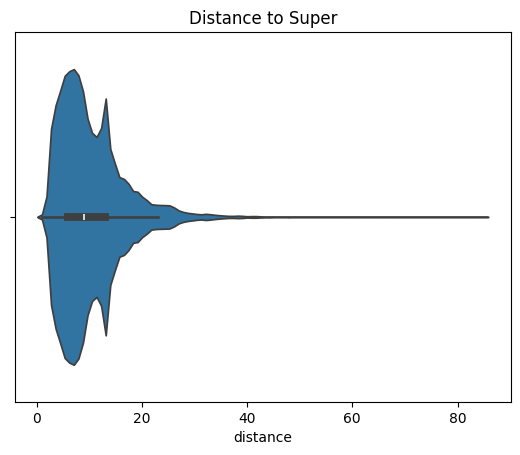

In [120]:
#plot violinplot for distance for each row
sns.violinplot( x=df_emtree_proc['distance'])
plt.title("Distance to Super")
plt.show

### Pre-processing


***For concepts having both ambiguous and unambiguous labels we keep only the rows of ambiguous as the data is skewed.***

In [121]:
#For concepts having both ambiguous and unambiguous labels we keep only the rows of ambiguous
temp_df = df_emtree_proc[(df_emtree_proc['concept'].isin(ambiguous_concepts)) & (df_emtree_proc['ambiguous'] == False)]

# Remove these rows from df_emtree_proc
df_emtree_proc = df_emtree_proc.drop(temp_df.index)

In [122]:
#Keep only one label for each concept. For now this is the first one but later maybe the preferred label in the taxonomy
df_emtree_proc = df_emtree_proc.sort_values('concept')
df_emtree_proc = df_emtree_proc.drop_duplicates(subset='concept', keep='first').drop(['super'],axis=1) #,'superLabel'

***For ambiguous concepts we remove the qualifier - the explanation inside the parenthesis - and keep it in a seperate collumn***

In [123]:
#Remove qualifier and put it in new column for ambiguous terms
# Create a mask for rows where 'ambiguous' is True
mask = df_emtree_proc['ambiguous'] == True

# Extract the qualifier and put it in a new column for these rows
df_emtree_proc.loc[mask, 'qualifier'] = df_emtree_proc.loc[mask, 'label'].str.extract(r'\((.*?)\)', expand=False)

# Remove the qualifier from the 'label' column for these rows
df_emtree_proc.loc[mask, 'label'] = df_emtree_proc.loc[mask, 'label'].str.replace(r'\s*\(.*?\)\s*', '', regex=True)


In [124]:
# reorder columnns
df_emtree_proc = df_emtree_proc[['concept', 'label', 'ambiguous','qualifier','label_list','distance','super_list','superLabel_list','word_count', 'superLabel']]

### Analysis 7: After pre-processing 

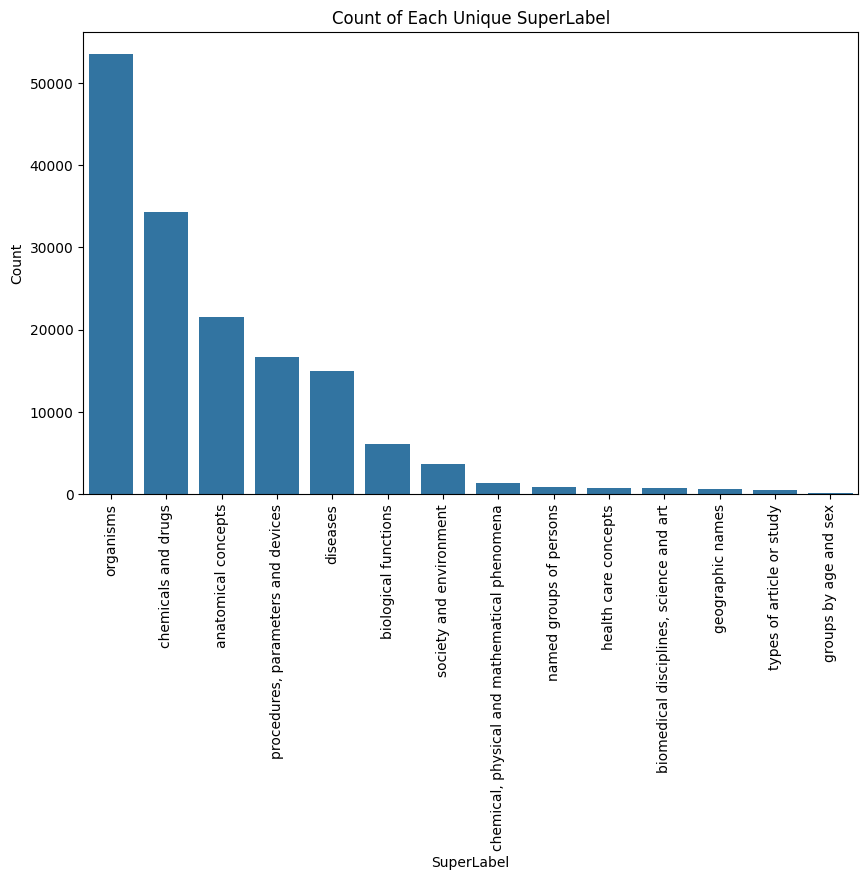

In [125]:
# Count the number of times each unique superLabel appears in the dataset
superLabel_counts = df_emtree_proc['superLabel'].value_counts().reset_index().rename(columns={'index': 'superLabel', 'superLabel': 'superLabel'})

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='superLabel', y='count', data=superLabel_counts)
plt.title('Count of Each Unique SuperLabel')
plt.xlabel('SuperLabel')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if they are long
plt.show()


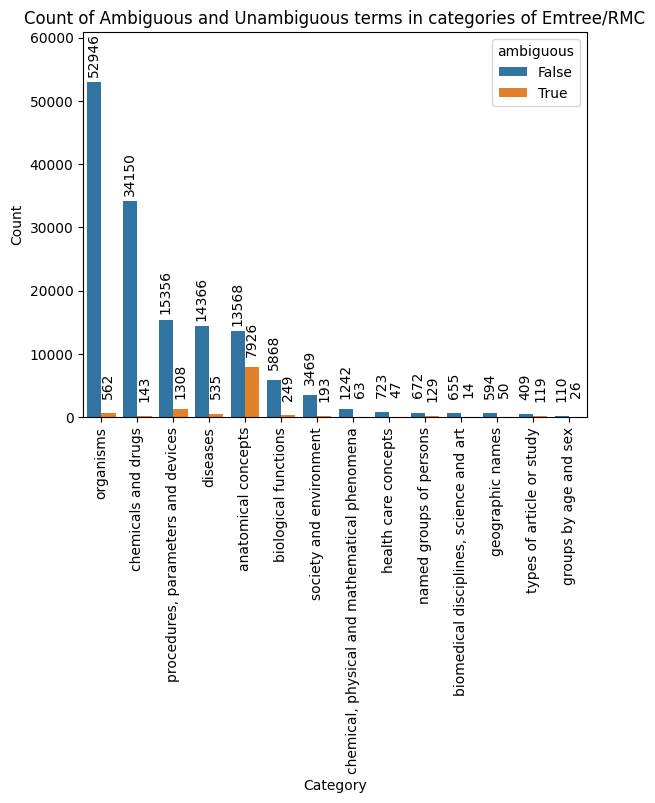

In [126]:
# Sort the DataFrame by count
super_ambiguity_counts = df_emtree_proc.groupby(['superLabel', 'ambiguous']).size().reset_index(name='count')
super_ambiguity_counts = super_ambiguity_counts.sort_values('count', ascending=False)

# Plot the bar chart
plt.figure(figsize=(6.5, 5))
bar_plot = sns.barplot(x='superLabel', y='count', hue='ambiguous', data=super_ambiguity_counts)

# Add the numbers above the bars  
for p in bar_plot.patches:  
    if p.get_height() > 0:  # Only annotate bars with height greater than 0  
        bar_plot.annotate(format(p.get_height(), '.0f'),   
                        (p.get_x() + p.get_width() / 2., p.get_height()),   
                        ha = 'center', va = 'center',   
                        xytext = (0, 20),  # Move the text 10 points above the bar  
                        textcoords = 'offset points',  
                        rotation=90)
    
# Adjust the y-axis limits to provide extra space at the top  
max_height = super_ambiguity_counts['count'].max()  
plt.ylim(0, max_height * 1.15)  # Increase the limit by 10%  

plt.title('Count of Ambiguous and Unambiguous terms in categories of Emtree/RMC')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



In [127]:

# Transform the ambiguous column into two columns Ambiguous and Unambiguous``
super_ambiguity_counts_pivot = super_ambiguity_counts.pivot(index='superLabel', columns='ambiguous', values='count').reset_index()

# Rename the columns
super_ambiguity_counts_pivot.columns = ['SuperLabel', 'Unambiguous', 'Ambiguous']

# Replace NaN values with 0
super_ambiguity_counts_pivot = super_ambiguity_counts_pivot.fillna(0)

# Add a new column for the full count
super_ambiguity_counts_pivot['Full Count'] = super_ambiguity_counts_pivot['Ambiguous'] + super_ambiguity_counts_pivot['Unambiguous']

# Add a new column for the percentage of ambiguity
super_ambiguity_counts_pivot['Ambiguity Percentage'] = (super_ambiguity_counts_pivot['Ambiguous'] / super_ambiguity_counts_pivot['Full Count']) * 100

# Calculate the total count of Ambiguous terms
total_ambiguous = super_ambiguity_counts_pivot['Ambiguous'].sum()

# Add a new column for the percentage of total ambiguous terms under each superLabel
super_ambiguity_counts_pivot['% of all Ambiguous'] = (super_ambiguity_counts_pivot['Ambiguous'] / total_ambiguous) * 100

# Print the DataFrame
print(super_ambiguity_counts_pivot.to_string(index=False))



                                   SuperLabel  Unambiguous  Ambiguous  Full Count  Ambiguity Percentage  % of all Ambiguous
                          anatomical concepts        13568       7926       21494             36.875407           69.746568
                         biological functions         5868        249        6117              4.070623            2.191130
      biomedical disciplines, science and art          655         14         669              2.092676            0.123196
chemical, physical and mathematical phenomena         1242         63        1305              4.827586            0.554382
                          chemicals and drugs        34150        143       34293              0.416995            1.258360
                                     diseases        14366        535       14901              3.590363            4.707849
                             geographic names          594         50         644              7.763975            0.439986
        

In [128]:
#print percentiles and mean for the length of super_list
descr_super = df_emtree_proc['super_list'].apply(len).describe(percentiles=[0.25,0.5,.75,.90,.99])
descr_super

count    155492.000000
mean          1.073509
std           0.311088
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
90%           1.000000
99%           3.000000
max           5.000000
Name: super_list, dtype: float64

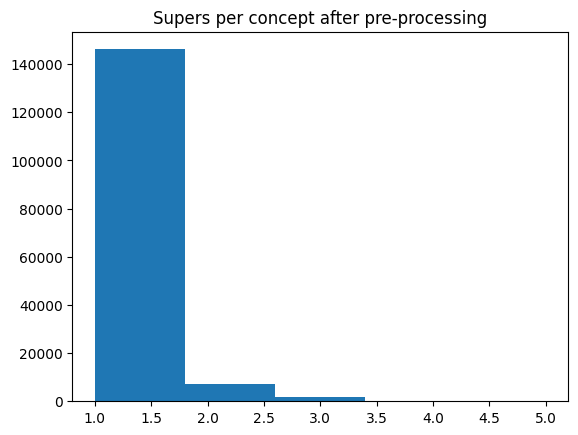

In [129]:
#Count unique supers that each concept has and plot it in a histogram
df_emtree_proc['super_list'].apply(len).value_counts()
plt.hist(df_emtree_proc['super_list'].apply(len),bins=int(descr_super['max']))
plt.title("Supers per concept after pre-processing")
plt.show()

In [130]:
#print percentiles and mean for the length of label_list
df_emtree_proc['label_list'].apply(len).describe(percentiles=[0.25,0.5,.75,.90,.99])


count    155492.000000
mean          4.054363
std           5.922764
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
90%           9.000000
99%          26.000000
max         305.000000
Name: label_list, dtype: float64

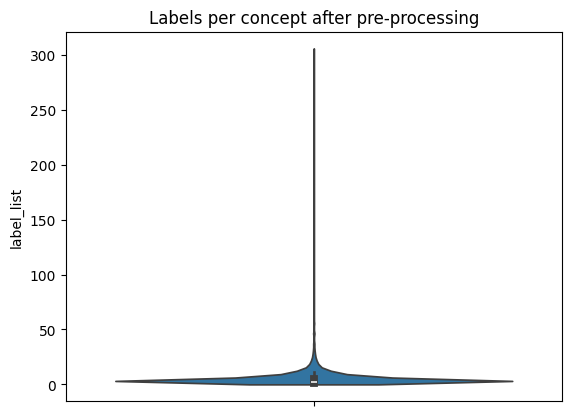

In [131]:
#Count unique labels that each concept and plot violinplot
df_emtree_proc['label_list'].apply(len).value_counts()
sns.violinplot( df_emtree_proc['label_list'].apply(len))
# plt.hist(df_emtree_proc['label_list'].apply(len),bins=5)
plt.title("Labels per concept after pre-processing")
plt.show()

In [132]:
#print percentiles and mean for word_count
descr_words = df_emtree_proc['word_count'].describe(percentiles=[0.25,0.5,.75,.8,.90,.99])
descr_words

count    155492.000000
mean          2.996283
std           1.952840
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
80%           4.000000
90%           5.000000
99%          12.000000
max          16.000000
Name: word_count, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

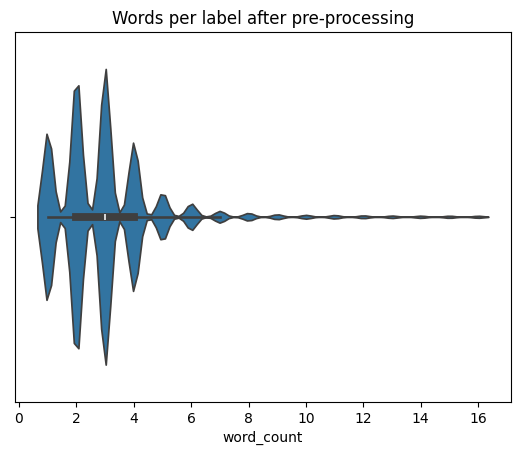

In [133]:
#Create word cound collumn 
sns.violinplot( x=df_emtree_proc['word_count'])
plt.title("Words per label after pre-processing")
plt.show

In [134]:
#show how many ambiguous and unambiguous labels there are left
df_emtree_proc['ambiguous'].value_counts()

ambiguous
False    144128
True      11364
Name: count, dtype: int64

In [135]:
#Number of words in ambiguous
descr_words_amb = df_emtree_proc.loc[df_emtree_proc['ambiguous']==True,'word_count'].describe(percentiles=[0.25,0.5,.75,.90,.99])
descr_words_amb

count    11364.000000
mean         3.367124
std          1.092338
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
90%          5.000000
99%          7.000000
max         12.000000
Name: word_count, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

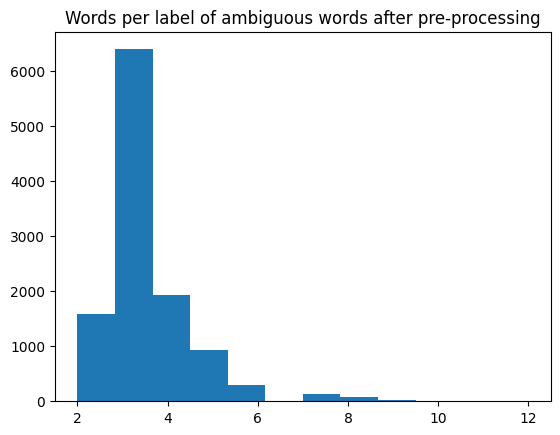

In [136]:
plt.hist(df_emtree_proc.loc[df_emtree_proc['ambiguous']==True,'word_count'],bins=int(descr_words_amb['max']))
# sns.violinplot( x=df_emtree_proc.loc[df_emtree_proc['ambiguous']==True,'word_count'])
plt.title("Words per label of ambiguous words after pre-processing")

plt.show

In [137]:
#Number of words in ambiguous
descr_words_unamb = df_emtree_proc.loc[df_emtree_proc['ambiguous']==False,'word_count'].describe(percentiles=[0.25,0.5,.75,.90,.99])
descr_words_unamb


count    144128.000000
mean          2.967043
std           2.002125
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
90%           5.000000
99%          12.000000
max          16.000000
Name: word_count, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

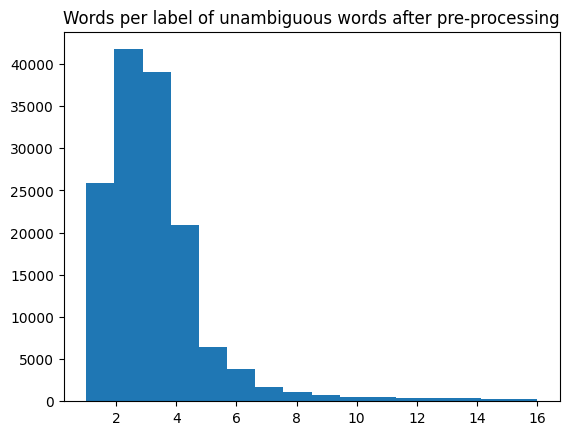

In [138]:
plt.hist(df_emtree_proc.loc[df_emtree_proc['ambiguous']==False,'word_count'],bins=int(descr_words_unamb['max']))
# sns.violinplot( x=df_emtree_proc.loc[df_emtree_proc['ambiguous']==False,'word_count'])
plt.title("Words per label of unambiguous words after pre-processing")
plt.show

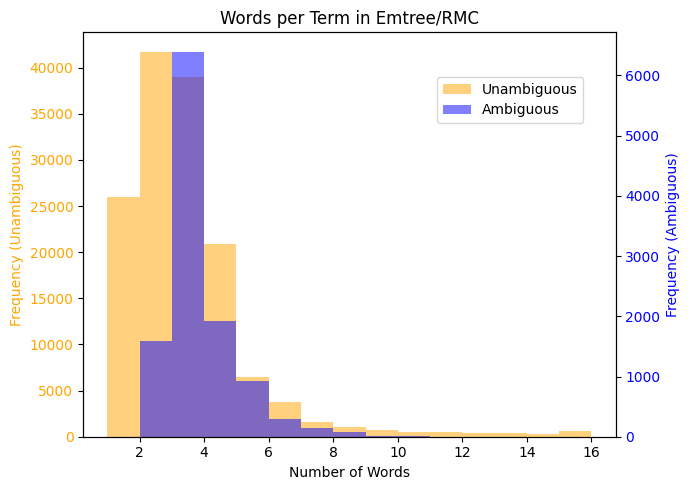

In [139]:
import matplotlib.pyplot as plt  

# Calculate the range of word counts  
min_word_count = df_emtree_proc['word_count'].min()  
max_word_count = df_emtree_proc['word_count'].max()  

# Define the bin edges  
bin_edges = range(min_word_count, max_word_count + 1)  

fig, ax1 = plt.subplots(figsize=(7,5))  

# Plot the histogram for unambiguous labels  
ax1.hist(df_emtree_proc.loc[df_emtree_proc['ambiguous'] == False, 'word_count'], bins=bin_edges, alpha=0.5, label='Unambiguous', color='orange')  
ax1.set_xlabel('Number of Words')  
ax1.set_ylabel('Frequency (Unambiguous)', color='orange')  
ax1.tick_params(axis='y', labelcolor='orange')  

# Create a secondary y-axis for the ambiguous labels  
ax2 = ax1.twinx()  
ax2.hist(df_emtree_proc.loc[df_emtree_proc['ambiguous'] == True, 'word_count'], bins=bin_edges, alpha=0.5, label='Ambiguous', color='blue')  
ax2.set_ylabel('Frequency (Ambiguous)', color='blue')  
ax2.tick_params(axis='y', labelcolor='blue')  

# Add titles and labels  
plt.title("Words per Term in Emtree/RMC")  
fig.tight_layout()  # Adjust layout to make room for both y-axes  

# Add legends  
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))  

# Show the plot  
plt.show()

In [140]:
#Distance to super
df_emtree_proc['distance'].describe()


count    155492.000000
mean         10.330937
std           5.358716
min           1.000000
25%           6.000000
50%          10.000000
75%          13.000000
max          85.000000
Name: distance, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

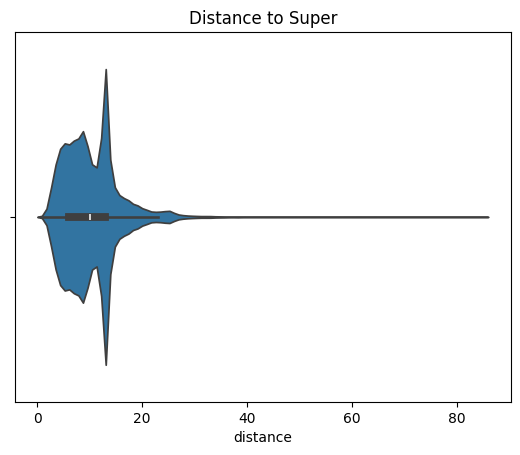

In [141]:
#Plot violinplot for distance for each row
sns.violinplot( x=df_emtree_proc['distance'])
plt.title("Distance to Super")
plt.show

### Save dataframe

In [142]:
#Save dataframe to csv for pipeline
# df_emtree_proc.to_csv("/Users/papadopoulosd/Documents/Ambiguity_scoring_project/Emtree_RMC_processed.csv",header=True)

## EDA for Omniscience

### Data Loading

In [143]:
df_omni = pd.read_csv("/home/dpapadopoulos/dsls-papadopoulos-ambiguity-scoring-thesis/Data/OmniScience.csv")

### Analysis 1: Concepts
Let us see how many unique concepts there are, and how many times (rows/occurances) they appear in the taxonomy.

In [144]:
#Count number of times a concept appears 
counts_concept = df_omni['concept'].value_counts().describe(percentiles=[.3, .6, .80, .90 ,.95])
counts_concept

count    57751.000000
mean         1.702083
std          1.630167
min          1.000000
30%          1.000000
50%          1.000000
60%          1.000000
80%          2.000000
90%          3.000000
95%          4.000000
max         99.000000
Name: count, dtype: float64

The Omniscience taxonomy has  57751.0  unique concepts, with  1.7020830808124534 average rows per concept.


<function matplotlib.pyplot.show(close=None, block=None)>

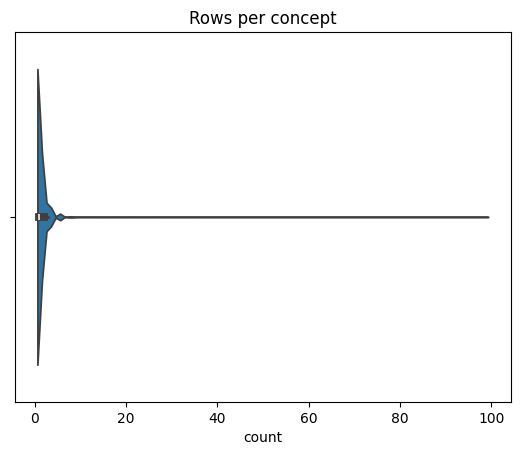

In [145]:
print("The Omniscience taxonomy has ", counts_concept['count'], " unique concepts, with ",counts_concept['mean'], "average rows per concept.")
sns.violinplot( x=df_omni['concept'].value_counts())
plt.title("Rows per concept")
plt.show

### Analysis 2: Labels and supers

In [146]:
#Create lists for supers and labels for each concept
temp_df1 = df_omni.groupby('concept')['superLabel'].apply(lambda x: list(x.unique())).reset_index().rename(columns={'superLabel': 'superLabel_list'})
temp_df2 = df_omni.groupby('concept')['super'].apply(lambda x: list(x.unique())).reset_index().rename(columns={'super': 'super_list'})
temp_df3 = df_omni.groupby('concept')['label'].apply(lambda x: list(x.unique())).reset_index().rename(columns={'label': 'label_list'})
df_omni_proc = pd.merge(df_omni, temp_df1, on='concept', how='left')
df_omni_proc = pd.merge(df_omni_proc, temp_df2, on='concept', how='left')
df_omni_proc = pd.merge(df_omni_proc, temp_df3, on='concept', how='left')

In [147]:
#print percentiles and mean for the length of super_list
descr_super =  df_omni_proc['super_list'].apply(len).describe(percentiles=[0.25,0.5,.75,.90,.99])
descr_super

count    98297.000000
mean         1.689278
std          0.763412
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
90%          3.000000
99%          4.000000
max          5.000000
Name: super_list, dtype: float64

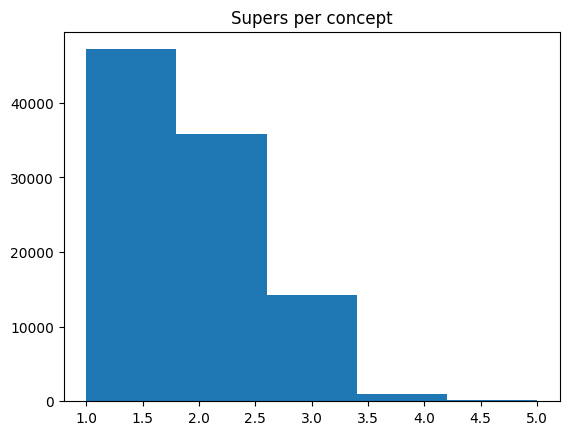

In [148]:
#Count unique supers that each concept has and plot it in a histogram
df_omni_proc['super_list'].apply(len).value_counts()
plt.hist(df_omni_proc['super_list'].apply(len),bins=int(descr_super['max']))
plt.title("Supers per concept")
plt.show()

In [149]:
#print percentiles and mean for the length of label_list
df_omni_proc['label_list'].apply(len).describe(percentiles=[0.25,0.5,.75,.90,.99])


count    98297.000000
mean         1.761224
std          2.109805
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
90%          3.000000
99%         11.000000
max         33.000000
Name: label_list, dtype: float64

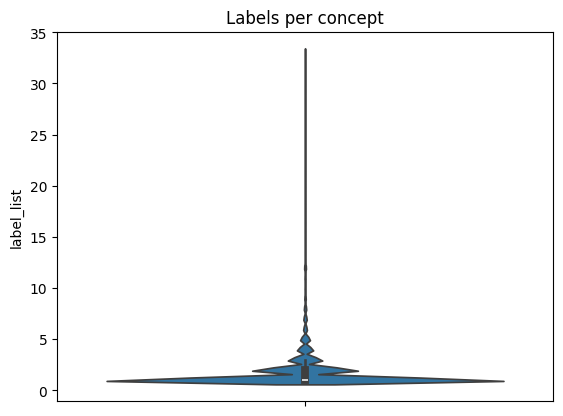

In [150]:
#Count unique labels that each concept and plot violinplot
df_omni_proc['label_list'].apply(len).value_counts()
sns.violinplot( df_omni_proc['label_list'].apply(len))
# plt.hist(df_omni_proc['label_list'].apply(len),bins=5)
plt.title("Labels per concept")
plt.show()

### Analysis 3: Words per label

<function matplotlib.pyplot.show(close=None, block=None)>

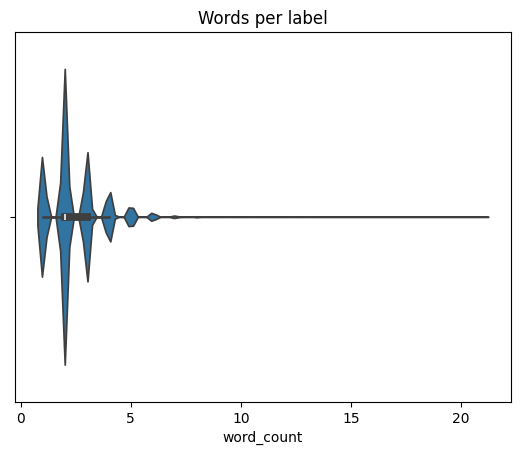

In [151]:
#Create word cound collumn 
df_omni_proc['word_count'] = df_omni_proc['label'].apply(lambda x: len(str(x).split()))
sns.violinplot( x=df_omni_proc['word_count'])
plt.title("Words per label")
plt.show

In [152]:
#print percentiles and mean for word_count
descr_words = df_omni_proc['word_count'].describe(percentiles=[0.25,0.5,.75,.8,.90,.99])
descr_words

count    98297.000000
mean         2.414723
std          1.179595
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
80%          3.000000
90%          4.000000
99%          6.000000
max         21.000000
Name: word_count, dtype: float64

In [153]:
#Define and remove outliers

# Define upper bound
upper_bound = df_omni_proc['word_count'].quantile(0.99)
# upper_bound = 16

# Identify outliers
outliers = df_omni_proc[df_omni_proc['word_count'] > upper_bound]
print("Number of outliers:", len(outliers))

# Count the number of outliers that are ambiguous
ambiguous_outliers = outliers[outliers['ambiguous'] == True]
print("Number of ambiguous outliers:", len(ambiguous_outliers))

# Filter the DataFrame
df_omni_proc = df_omni_proc[df_omni_proc['word_count'] <= upper_bound]

print("Number of records after removing outliers:", len(df_omni_proc))


Number of outliers: 620
Number of ambiguous outliers: 16
Number of records after removing outliers: 97677


### Analysis 4: Ambiguity


In [154]:
#show how many ambiguous and unambiguous labels there are
val_amb_omni = df_omni_proc['ambiguous'].value_counts()
print("Ratio = ",val_amb_omni[True]/val_amb_omni[False])
val_amb_omni

Ratio =  0.0185084774040166


ambiguous
False    95902
True      1775
Name: count, dtype: int64

In [155]:
#Number of words in ambiguous
descr_words_amb = df_omni_proc.loc[df_omni_proc['ambiguous']==True,'word_count'].describe(percentiles=[0.25,0.5,.75,.90,.99])
descr_words_amb

count    1775.00000
mean        3.23662
std         0.86215
min         2.00000
25%         3.00000
50%         3.00000
75%         4.00000
90%         4.00000
99%         6.00000
max         6.00000
Name: word_count, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

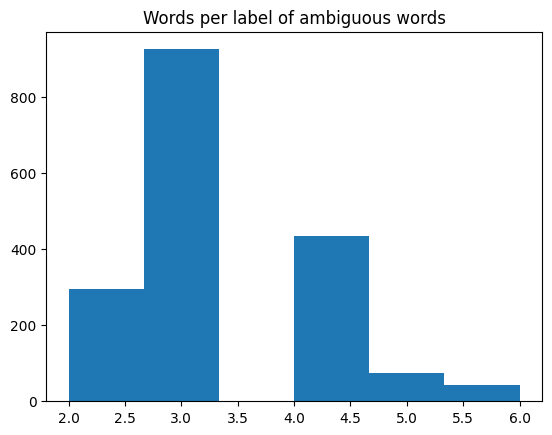

In [156]:
plt.hist(df_omni_proc.loc[df_omni_proc['ambiguous']==True,'word_count'],bins=int(descr_words_amb['max']))
# sns.violinplot( x=df_omni_proc.loc[df_omni_proc['ambiguous']==True,'word_count'])
plt.title("Words per label of ambiguous words")

plt.show

In [157]:
#Number of words in unambiguous
descr_words_unamb = df_omni_proc.loc[df_omni_proc['ambiguous']==False,'word_count'].describe(percentiles=[0.25,0.5,.75,.90])
descr_words_unamb

count    95902.000000
mean         2.365519
std          1.099653
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
90%          4.000000
max          6.000000
Name: word_count, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

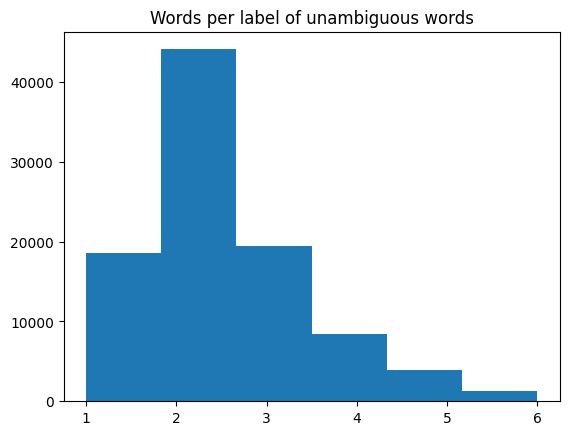

In [158]:
plt.hist(df_omni_proc.loc[df_omni_proc['ambiguous']==False,'word_count'],bins=int(descr_words_unamb['max']))
# sns.violinplot( x=df_omni_proc.loc[df_omni_proc['ambiguous']==False,'word_count'])
plt.title("Words per label of unambiguous words")
plt.show

We can see that ambiguous words have a slightly higher mean of number of words per label. What is particularly apparent is that there is not a single ambiguous label that is only one word. Furthermore, the standard deviation for the unambiguous words is higher than ambiguous.

### Analysis 5: Ambiguous and unambiguous labels of the same concept


In [159]:
#Find concepts that have both True and False values in ' ambiguous'. Similarly for only True or False
ambiguous_concepts = df_omni_proc.groupby('concept')['ambiguous'].apply(lambda x: set(x) == {True, False})
ambiguous_concepts = ambiguous_concepts[ambiguous_concepts].index.tolist()


true_only_concepts = df_omni_proc.groupby('concept')['ambiguous'].apply(lambda x: set(x) == {True})
true_only_concepts = true_only_concepts[true_only_concepts].index.tolist()

false_only_concepts = df_omni_proc.groupby('concept')['ambiguous'].apply(lambda x: set(x) == {False})
false_only_concepts = false_only_concepts[false_only_concepts].index.tolist()

print("There are ",len(ambiguous_concepts)," concepts that have both ambiguous and unambiguous labels.")
print("There are ",len(true_only_concepts)," concepts that have only ambiguous labels.")
print("There are ",len(false_only_concepts)," concepts that have only unambiguous labels.")


There are  857  concepts that have both ambiguous and unambiguous labels.
There are  282  concepts that have only ambiguous labels.
There are  56266  concepts that have only unambiguous labels.


### Analysis 6: Distance from concept to super in the taxonomy


In [160]:
df_omni_proc['distance'].describe()


count    97677.000000
mean         8.605598
std          5.315702
min          1.000000
25%          5.000000
50%          7.000000
75%         10.000000
max         67.000000
Name: distance, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

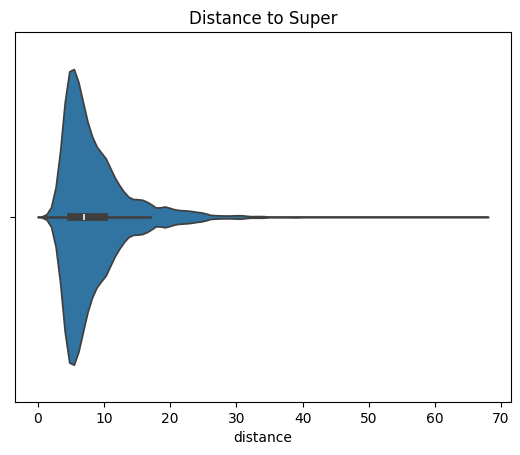

In [161]:
#plot violinplot for distance for each row
sns.violinplot( x=df_omni_proc['distance'])
plt.title("Distance to Super")
plt.show

### Pre-processing


***For ambiguous concepts we remove the qualifier - the explanation inside the parenthesis - and keep it in a seperate collumn***

In [162]:
#Remove qualifier and put it in new column for ambiguous terms
# Create a mask for rows where 'ambiguous' is True
mask = df_omni_proc['ambiguous'] == True

# Extract the qualifier and put it in a new column for these rows
df_omni_proc.loc[mask, 'qualifier'] = df_omni_proc.loc[mask, 'label'].str.extract(r'\((.*?)\)', expand=False)

# Remove the qualifier from the 'label' column for these rows
df_omni_proc.loc[mask, 'label'] = df_omni_proc.loc[mask, 'label'].str.replace(r'\s*\(.*?\)\s*', '', regex=True)


In [163]:
#For omniscience we have to check whether a concept occurs multiple times without the qualifier.
# Filter the DataFrame for rows where 'ambiguous' is True
ambiguous_df = df_omni_proc[df_omni_proc['ambiguous'] == True]

# Group by 'concept' and 'label', count the size of each group, and filter for counts greater than 1
ambiguous_duplicates = ambiguous_df.groupby(['concept', 'label']).size().reset_index(name='count')
ambiguous_duplicates = ambiguous_duplicates[ambiguous_duplicates['count'] > 1]


In [164]:

# Get the unique 'concept'-'label' pairs in the ambiguous DataFrame
ambiguous_pairs = set(zip(ambiguous_df['concept'], ambiguous_df['label']))

# Get the unique 'concept'-'label' pairs in the whole DataFrame
all_pairs = set(zip(df_omni_proc['concept'], df_omni_proc['label']))

# Find the 'concept'-'label' pairs that are in the ambiguous DataFrame but also appear under a different concept in the whole DataFrame
ambiguous_duplicates = [(concept, label) for concept, label in ambiguous_pairs if any((c, label) in all_pairs for c in df_omni_proc['concept'].unique() if c != concept)]

# Create a new column in the original DataFrame to indicate whether each row is a duplicate
df_omni_proc['duplicate'] = df_omni_proc.apply(lambda row: (row['concept'], row['label']) in ambiguous_duplicates, axis=1)


In [165]:
# Filter the DataFrame for rows where both 'ambiguous' and 'duplicate' are True
ambiguous_and_duplicate_df = df_omni_proc[(df_omni_proc['ambiguous'] == True) & (df_omni_proc['duplicate'] == True)]

# Get the number of unique concepts in the filtered DataFrame
unique_concepts_count = ambiguous_and_duplicate_df['concept'].nunique()

# Print the number of unique concepts
print(f"The number of unique concepts that are both ambiguous and duplicate is: {unique_concepts_count}")

The number of unique concepts that are both ambiguous and duplicate is: 645


In [166]:
#Change ambiguous to False for those that don't appear under different concept
# Get the list of unique concepts that are both ambiguous and duplicate
ambiguous_and_duplicate_concepts = ambiguous_and_duplicate_df['concept'].unique()

# Change 'ambiguous' to False for concepts that are not in the list
df_omni_proc.loc[~df_omni_proc['concept'].isin(ambiguous_and_duplicate_concepts), 'ambiguous'] = False



In [167]:
#For concepts having both ambiguous and unambiguous labels we keep only the rows of ambiguous as the data is skewed.
temp_df = df_omni_proc[(df_omni_proc['concept'].isin(ambiguous_concepts)) & (df_omni_proc['ambiguous'] == False)]

# Remove these rows from df_emtree
df_omni_proc = df_omni_proc.drop(temp_df.index)

In [168]:
#Keep only one label for each concept. For now this is the first one but later maybe the preferred label in the taxonomy
df_omni_proc = df_omni_proc.sort_values('concept')
df_omni_proc = df_omni_proc.drop_duplicates(subset='concept', keep='first').drop(['super'],axis=1) #,'superLabel'

In [169]:
# reorder columnns
df_omni_proc = df_omni_proc[['concept', 'label', 'ambiguous','qualifier','label_list','distance','super_list','superLabel_list','word_count','superLabel']]

### Analysis 7: After pre-processing 

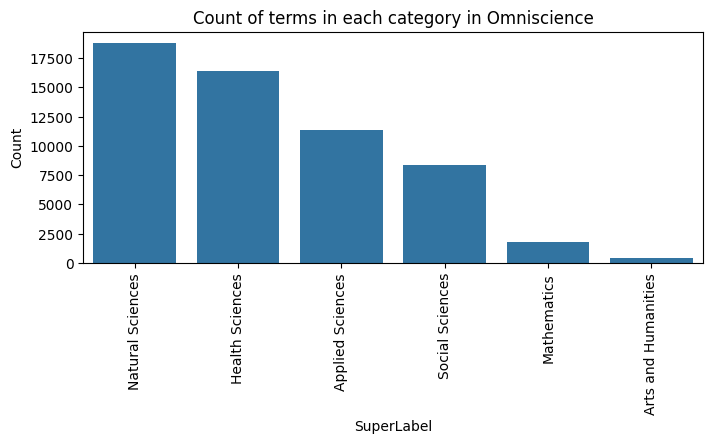

In [170]:
# Count the number of times each unique superLabel appears in the dataset
superLabel_counts = df_omni_proc['superLabel'].value_counts().reset_index().rename(columns={'index': 'superLabel', 'superLabel': 'superLabel'})

# Plot the bar chart
plt.figure(figsize=(8, 3))
sns.barplot(x='superLabel', y='count', data=superLabel_counts)
plt.title('Count of terms in each category in Omniscience')
plt.xlabel('SuperLabel')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if they are long
plt.show()


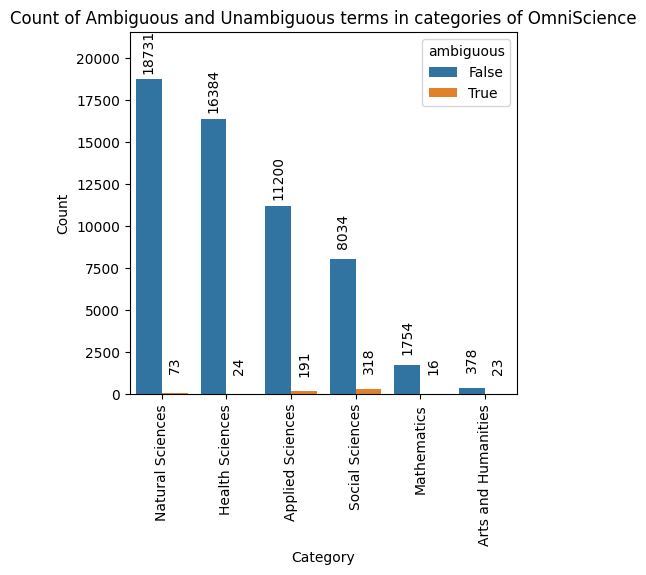

In [171]:
# Sort the DataFrame by count
super_ambiguity_counts = df_omni_proc.groupby(['superLabel', 'ambiguous']).size().reset_index(name='count')
super_ambiguity_counts = super_ambiguity_counts.sort_values('count', ascending=False)

# Plot the bar chart
plt.figure(figsize=(5, 4.7))
bar_plot = sns.barplot(x='superLabel', y='count', hue='ambiguous', data=super_ambiguity_counts)

# Add the numbers above the bars  
for p in bar_plot.patches:  
    if p.get_height() > 0:  # Only annotate bars with height greater than 0  
        bar_plot.annotate(format(p.get_height(), '.0f'),   
                        (p.get_x() + p.get_width() / 2., p.get_height()),   
                        ha = 'center', va = 'center',   
                        xytext = (0, 20),  # Move the text 10 points above the bar  
                        textcoords = 'offset points',  
                        rotation=90)
    
# Adjust the y-axis limits to provide extra space at the top  
max_height = super_ambiguity_counts['count'].max()  
plt.ylim(0, max_height * 1.15)  # Increase the limit by 10%  

plt.title('Count of Ambiguous and Unambiguous terms in categories of OmniScience')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()




In [172]:

# Transform the ambiguous column into two columns Ambiguous and Unambiguous``
super_ambiguity_counts_pivot = super_ambiguity_counts.pivot(index='superLabel', columns='ambiguous', values='count').reset_index()

# Rename the columns
super_ambiguity_counts_pivot.columns = ['SuperLabel', 'Unambiguous', 'Ambiguous']

# Replace NaN values with 0
super_ambiguity_counts_pivot = super_ambiguity_counts_pivot.fillna(0)

# Add a new column for the full count
super_ambiguity_counts_pivot['Full Count'] = super_ambiguity_counts_pivot['Ambiguous'] + super_ambiguity_counts_pivot['Unambiguous']

# Add a new column for the percentage of ambiguity
super_ambiguity_counts_pivot['Ambiguity Percentage'] = (super_ambiguity_counts_pivot['Ambiguous'] / super_ambiguity_counts_pivot['Full Count']) * 100

# Calculate the total count of Ambiguous terms
total_ambiguous = super_ambiguity_counts_pivot['Ambiguous'].sum()

# Add a new column for the percentage of total ambiguous terms under each superLabel
super_ambiguity_counts_pivot['% of all Ambiguous'] = (super_ambiguity_counts_pivot['Ambiguous'] / total_ambiguous) * 100

# Print the DataFrame
print(super_ambiguity_counts_pivot.to_string(index=False))



         SuperLabel  Unambiguous  Ambiguous  Full Count  Ambiguity Percentage  % of all Ambiguous
   Applied Sciences        11200        191       11391              1.676762           29.612403
Arts and Humanities          378         23         401              5.735661            3.565891
    Health Sciences        16384         24       16408              0.146270            3.720930
        Mathematics         1754         16        1770              0.903955            2.480620
   Natural Sciences        18731         73       18804              0.388215           11.317829
    Social Sciences         8034        318        8352              3.807471           49.302326


In [173]:
#print percentiles and mean for the length of super_list
descr_super = df_omni_proc['super_list'].apply(len).describe(percentiles=[0.25,0.5,.75,.90,.99])
descr_super

count    57126.000000
mean         1.370024
std          0.610433
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
90%          2.000000
99%          3.000000
max          5.000000
Name: super_list, dtype: float64

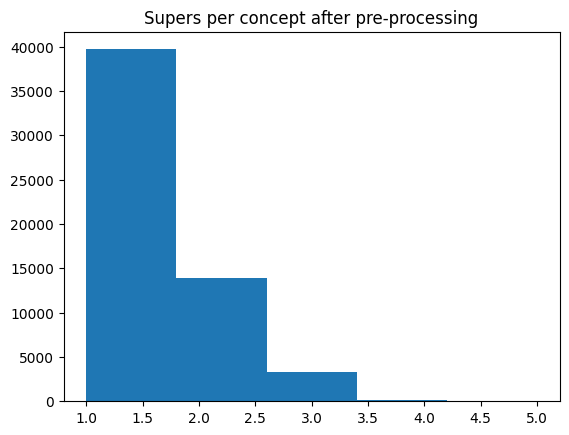

In [174]:
#Count unique supers that each concept has and plot it in a histogram
df_omni_proc['super_list'].apply(len).value_counts()
plt.hist(df_omni_proc['super_list'].apply(len),bins=int(descr_super['max']))
plt.title("Supers per concept after pre-processing")
plt.show()

In [175]:
#print percentiles and mean for the length of label_list
df_omni_proc['label_list'].apply(len).describe(percentiles=[0.25,0.5,.75,.90,.99])


count    57126.000000
mean         1.207541
std          0.698850
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
90%          2.000000
99%          4.000000
max         33.000000
Name: label_list, dtype: float64

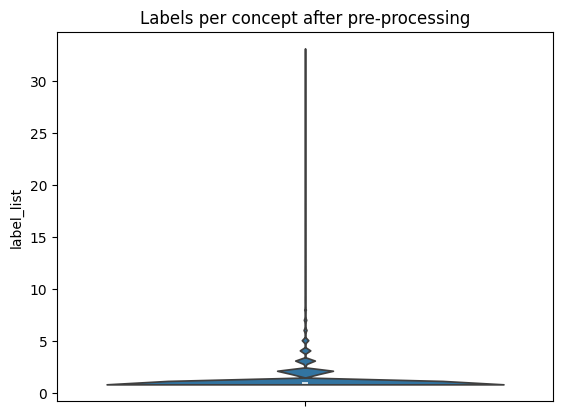

In [176]:
#Count unique labels that each concept and plot violinplot
df_omni_proc['label_list'].apply(len).value_counts()
sns.violinplot( df_omni_proc['label_list'].apply(len))
# plt.hist(df_omni_proc['label_list'].apply(len),bins=5)
plt.title("Labels per concept after pre-processing")
plt.show()

In [177]:
#print percentiles and mean for word_count
descr_words = df_omni_proc['word_count'].describe(percentiles=[0.25,0.5,.75,.8,.90,.99])
descr_words

count    57126.000000
mean         2.373980
std          1.090835
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
80%          3.000000
90%          4.000000
99%          6.000000
max          6.000000
Name: word_count, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

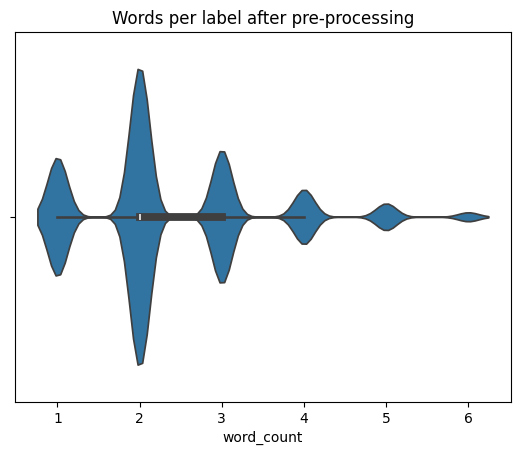

In [178]:
#Create word cound collumn 
sns.violinplot( x=df_omni_proc['word_count'])
plt.title("Words per label after pre-processing")
plt.show

In [179]:
#show how many ambiguous and unambiguous labels there are left
df_omni_proc['ambiguous'].value_counts()

ambiguous
False    56481
True       645
Name: count, dtype: int64

In [180]:
#Number of words in ambiguous
descr_words_amb = df_omni_proc.loc[df_omni_proc['ambiguous']==True,'word_count'].describe(percentiles=[0.25,0.5,.75,.90,.99])
descr_words_amb

count    645.000000
mean       3.271318
std        0.761577
min        2.000000
25%        3.000000
50%        3.000000
75%        4.000000
90%        4.000000
99%        6.000000
max        6.000000
Name: word_count, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

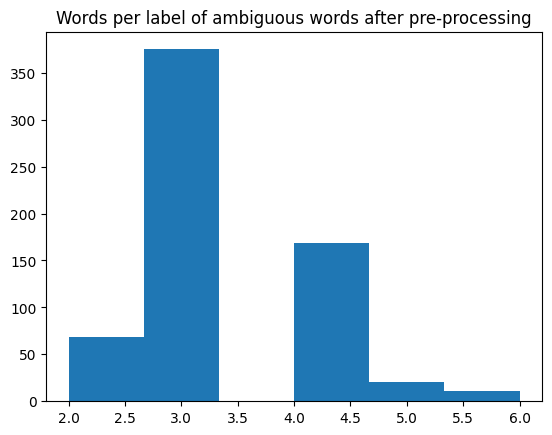

In [181]:
plt.hist(df_omni_proc.loc[df_omni_proc['ambiguous']==True,'word_count'],bins=int(descr_words_amb['max']))
# sns.violinplot( x=df_omni_proc.loc[df_omni_proc['ambiguous']==True,'word_count'])
plt.title("Words per label of ambiguous words after pre-processing")

plt.show

In [182]:
#Number of words in ambiguous
descr_words_unamb = df_omni_proc.loc[df_omni_proc['ambiguous']==False,'word_count'].describe(percentiles=[0.25,0.5,.75,.90,.99])
descr_words_unamb


count    56481.000000
mean         2.363733
std          1.089769
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
90%          4.000000
99%          6.000000
max          6.000000
Name: word_count, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

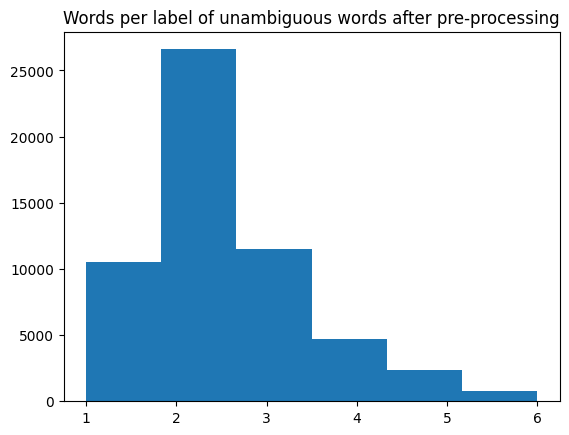

In [183]:
plt.hist(df_omni_proc.loc[df_omni_proc['ambiguous']==False,'word_count'],bins=int(descr_words_unamb['max']))
# sns.violinplot( x=df_omni_proc.loc[df_omni_proc['ambiguous']==False,'word_count'])
plt.title("Words per label of unambiguous words after pre-processing")
plt.show

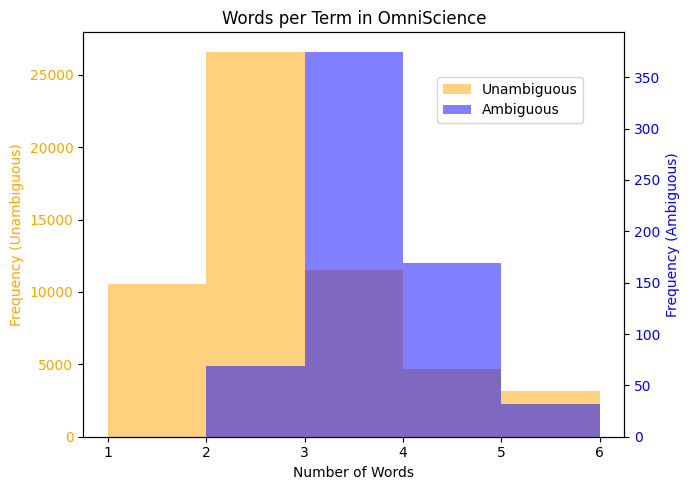

In [184]:
import matplotlib.pyplot as plt  

# Calculate the range of word counts  
min_word_count = df_omni_proc['word_count'].min()  
max_word_count = df_omni_proc['word_count'].max()  

# Define the bin edges  
bin_edges = range(min_word_count, max_word_count + 1)  

fig, ax1 = plt.subplots(figsize=(7,5))  

# Plot the histogram for unambiguous labels  
ax1.hist(df_omni_proc.loc[df_omni_proc['ambiguous'] == False, 'word_count'], bins=bin_edges, alpha=0.5, label='Unambiguous', color='orange')  
ax1.set_xlabel('Number of Words')  
ax1.set_ylabel('Frequency (Unambiguous)', color='orange')  
ax1.tick_params(axis='y', labelcolor='orange')  

# Create a secondary y-axis for the ambiguous labels  
ax2 = ax1.twinx()  
ax2.hist(df_omni_proc.loc[df_omni_proc['ambiguous'] == True, 'word_count'], bins=bin_edges, alpha=0.5, label='Ambiguous', color='blue')  
ax2.set_ylabel('Frequency (Ambiguous)', color='blue')  
ax2.tick_params(axis='y', labelcolor='blue')  

# Add titles and labels  
plt.title("Words per Term in OmniScience")  
fig.tight_layout()  # Adjust layout to make room for both y-axes  

# Add legends  
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))  

# Show the plot  
plt.show()

In [185]:
#Distance to super
df_omni_proc['distance'].describe()


count    57126.000000
mean         7.974968
std          4.790885
min          1.000000
25%          5.000000
50%          6.000000
75%         10.000000
max         52.000000
Name: distance, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

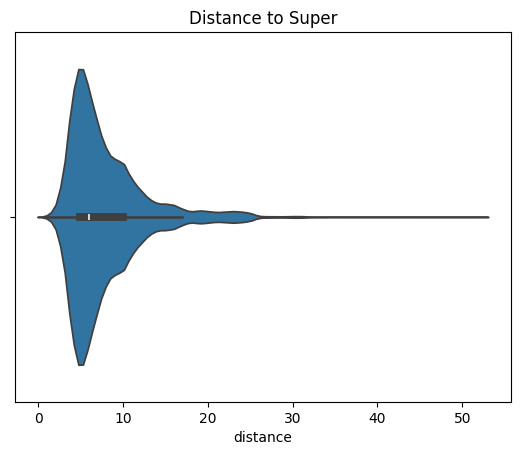

In [186]:
#Plot violinplot for distance for each row
sns.violinplot( x=df_omni_proc['distance'])
plt.title("Distance to Super")
plt.show

### Save dataframe

In [187]:
#Save dataframe to csv for pipeline
# df_omni_proc.to_csv("/Users/papadopoulosd/Documents/Ambiguity_scoring_project/Omniscience_processed.csv",header=True)